This notebook provides the code and steps for preprocessing the calendar data. It applies various techniques to clean and format the data, generates new data for the missing time period, and visualizes the data using plots and charts. To address the missing time period from April 22, 2021, to June 7, 2022, new data has been generated to fill the gap in the dataset.

In [ ]:
# Imports
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import scipy
import scipy.stats as stats

import seaborn as sns

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
print("  Package versions")
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", matplotlib.__version__)

print("scipy version:", scipy.__version__)
print("Seaborn version:", sns.__version__)
print("statsmodels version:", statsmodels.__version__)

  Package versions
pandas version: 1.5.3
numpy version: 1.22.4
matplotlib version: 3.7.1
scipy version: 1.10.1
Seaborn version: 0.12.2
statsmodels version: 0.13.5


In [ ]:
# data path to datasets
data_path = '[insert path to csv file here]'

In [ ]:
# Load Dataframe
df = pd.read_csv(data_path + 'unprocessed_calendar.csv', parse_dates=['date'])

# Pre-Process Calendar data

In [ ]:
# Remove duplicates
# The drop_duplicates() method removes duplicate
# rows from the DataFrame, keeping only
# the first occurrence of each unique row
df = df.drop_duplicates()

In [ ]:
# Drop irrelevant columns such as:
# "available", "adjusted_price",
# "minimum_nights", and "maximum_nights"
# columns inside brackets "[[...]]" are kept
df = df[['listing_id', 'date', 'price']]


In [ ]:
# Check for missing values
print(df.isnull().sum())

listing_id       0
date             0
price         1114
dtype: int64


In [ ]:
# Create a new DataFrame containing only the missing values
missing_values_df = df[df.isnull().any(axis=1)].copy()

# Drop rows with missing values on the "price" column
# inplace=True: This parameter specifies that the operation should be
# performed directly on the DataFrame df without creating a new DataFrame
df.dropna(subset=['price'], inplace=True)

# Drop price column on missing_values_df
missing_values_df = missing_values_df.drop('price', axis=1)

In [ ]:
# Remove Certain characters from Dataframe
# remove "$" and "," characters from "price" column
# By specifying regex=False in the replace() function calls, you ensure that the
# dollar sign ('$') and commas (',') are treated as literal strings and not as regular expression patterns.
df['price'] = df['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)


# Visualize Calendar data

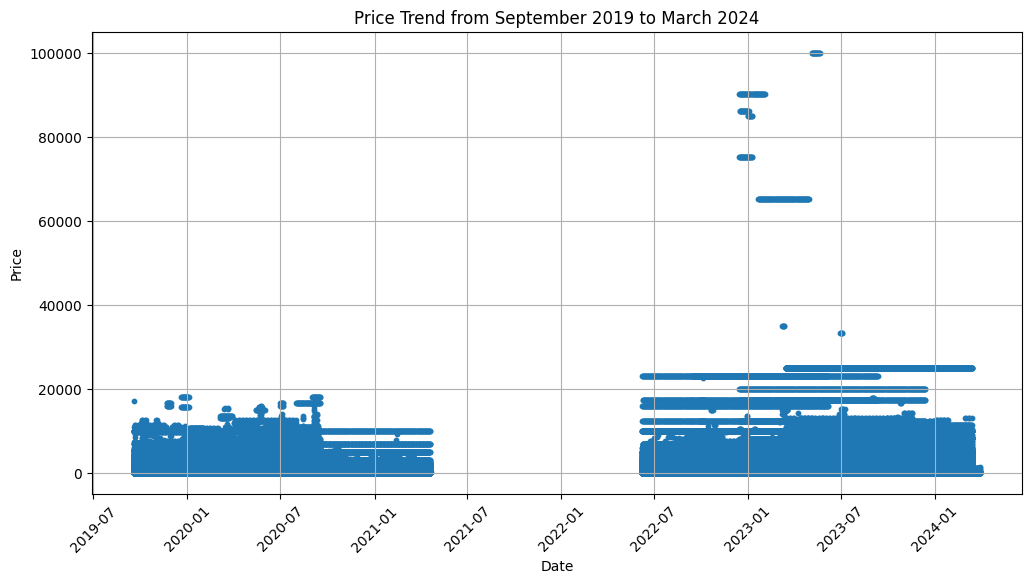

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(df['date'], df['price'], s=10)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Trend from September 2019 to March 2024')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Based on the data visualization, outliers have been identified and it is necessary to eliminate them. There is a a gap in the data. New data should be generated.
<br>


In [ ]:
def plot_price_distribution(data, title):
  '''
  Plot a price distribution histogram.
  Parameters:
  data: pandas DataFrame column or a numpy array
  text (str): Text of given title for plot

  Returns: Histogram plot
  '''
  plt.hist(data, bins='auto', edgecolor='blue')
  plt.xlabel('Price in Dollars ($)', fontsize=16)
  plt.ylabel('Frequency', fontsize=16)
  plt.title(title, fontsize=18)
  plt.show()


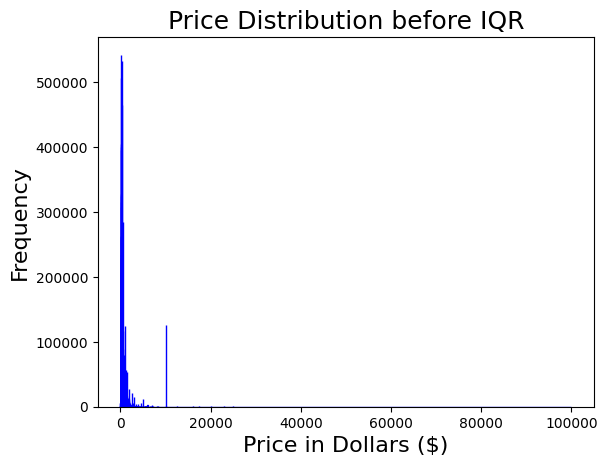

In [ ]:
plot_price_distribution(df['price'], 'Price Distribution before IQR')


Histogram:
Plotting a histogram of your data can provide a visual indication of its distribution. If the histogram exhibits a roughly symmetric bell-shaped curve, it suggests a normal distribution. NOTE: this method is subjective and can be influenced by the bin size chosen for the histogram.
<br>
<br>
The histogram reveals that the distribution is skewed towards lower values, indicating a higher concentration of observations in that range compared to higher values. Extreme ouliers have also been detected.
<br>
<br>
Overall, it is challenging to conclude if the data is normally distributed. A Kernel Density Estimation (KDE) Plot may be used as an alternative
<br>


In [ ]:
def plot_price_kde(data, title):
  """
  Plot the Kernel Density Estimation (KDE) of price data.
  Parameters:
  data: pandas data frame column or a numpy array
  title (str): Text of given title for plot

  Returns: displays the KDE plot
  """
  sns.kdeplot(data)
  plt.xlabel('Price')
  plt.ylabel('Density')
  plt.title(title)
  plt.show()

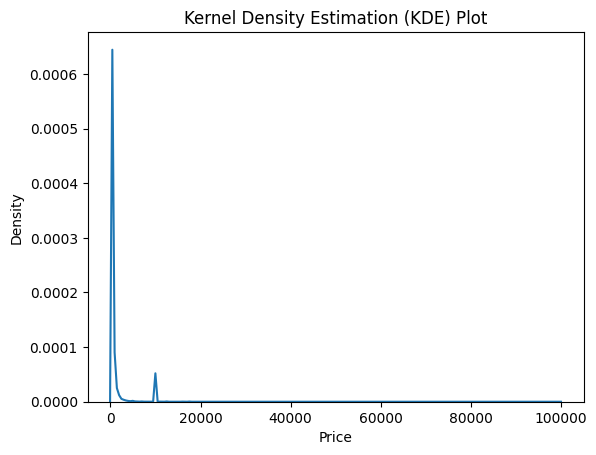

In [ ]:
plot_price_kde(df['price'], 'Kernel Density Estimation (KDE) Plot')



Kernel Density Estimation (KDE) Plot:
* A KDE plot provides a smoothed estimate of the data's probability density function. It can offer a more nuanced view of the data distribution compared to a histogram.
* If the KDE plot resembles a bell-shaped curve similar to a normal distribution, it suggests that the data is approximately normally distributed.
<br>
<br>
The KDE plot reveals a higher concentration of observations with lower values in the distribution, as opposed to higher values.

## Remove Outliers using IQR

In [ ]:
# make a copy of dataframe that does not
# have IQR implementation
no_iqr_df = df.copy()

When using a small multiplier like 0.5, the range for identifying outliers becomes narrower. This means that only data points that are very close to the median are considered as non-outliers, while data points that deviate even slightly from the central tendency are flagged as outliers and potentially removed.
<br>
<br>
When using a larger multiplier like 3 or 4, the range for identifying outliers becomes wider. This allows for a larger deviation from the central tendency before a data point is flagged as an outlier. As a result, fewer data points are likely to be identified as outliers and removed from the dataset.
<br>
<br>
The choice of multiplier depends on the specific context and the nature of the data.

In [ ]:
def remove_outliers_iqr(data, column, multiplier):
  """
  Remove outliers from a DataFrame based on the Traditional
  interquartile range (IQR) method of a specific column.

  Parameters:
    data (pandas.DataFrame): The DataFrame containing the data.
    column (str): The column name containing the data to be analyzed.
    multiplier (int): constant value that is multiplied by the IQR

  Returns:
    pandas.DataFrame: The DataFrame with outliers removed.
    """
  Q1 = data[column].quantile(0.25)
  Q3 = data[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_threshold = Q1 - multiplier * IQR
  upper_threshold = Q3 + multiplier * IQR
  filtered_data = data[(data[column] >= lower_threshold) & (data[column] <= upper_threshold)]
  return filtered_data


In [ ]:
# Call the function to remove outliers from the 'price' column in df
df = remove_outliers_iqr(df, 'price', 0.5)

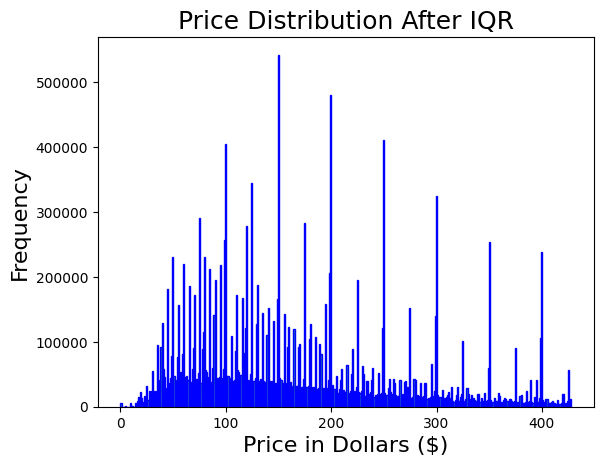

In [ ]:
# plot histogram to visualize changes
plot_price_distribution(df['price'], 'Price Distribution After IQR')

Histogram demonstrates succesful implementation of IQR with multiplier of 0.5. Extreme outliers have been remvoed.

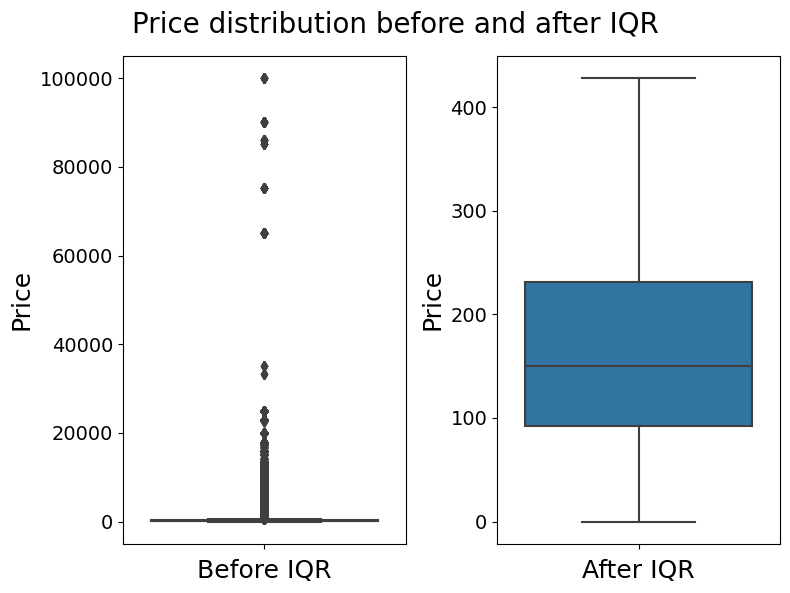

In [ ]:
# Create subplots for before and after
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

# Plot before IQR
sns.boxplot(data=no_iqr_df, y='price', ax=axes[0])
axes[0].set_xlabel('Before IQR', fontsize=18)
axes[0].set_ylabel('Price', fontsize=18)

# Plot after IQR
sns.boxplot(data=df, y='price', ax=axes[1])
axes[1].set_xlabel('After IQR', fontsize=18)
axes[1].set_ylabel('Price', fontsize=18)

# Increase the size of y-axis tick labels
axes[0].tick_params(axis='y', labelsize=14)  # Adjust the font size as needed
axes[1].tick_params(axis='y', labelsize=14)  # Adjust the font size as needed


# Set title for the overall figure
fig.suptitle('Price distribution before and after IQR', fontsize=20, ha='center')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

 Price distribution depicting before and after IQR implementation
Before: The boxplot of prices shows a broader and more varied range, with values spanning from lower to higher price points. The whiskers extend to the minimum and maximum values, indicating the presence of extreme outliers. After: A significant reduction in the spread of prices is observed in the box plot, indicating that the implementation of the IQR technique has effectively filtered out extreme outliers from the dataset. The whiskers now represent the data within a reasonable range, while the box itself represents the interquartile range (IQR) containing the central 50% of the data. The median line indicates the central tendency of the distribution.


In [ ]:
# Summary Statistics
df['price'].describe()

count    1.978449e+07
mean     1.698809e+02
std      9.841705e+01
min      0.000000e+00
25%      9.200000e+01
50%      1.500000e+02
75%      2.310000e+02
max      4.280000e+02
Name: price, dtype: float64

# Fill in missing time period of 04/22/2021 to 06/07/2022

In [ ]:
# Extract the day of the week from the date column and create a new column
df['day_of_week'] = df['date'].dt.day_name()

In [ ]:
# Calculate the average price per listing_id for each day of the week
# the average prices will be rounded to the nearest whole number.
average_prices = df.groupby(['listing_id', 'day_of_week'])['price'].mean().round().reset_index()

In [ ]:
# Find total amount of unique listing in calendar data
unique_listing_ids = average_prices['listing_id'].unique() # len(unique_listing_ids) = 27,513
print("Number of unique listing_id's:", len(unique_listing_ids))

Number of unique listing_id's: 27513


In [ ]:
# Create a new DataFrame with missing time period: April 22, 2021 to June 07, 2022 --> 412 days
start_date = '2021-04-22'
end_date = '2022-06-07'

# create date range
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# get all unique listing_id's
unique_listing_ids = average_prices['listing_id'].unique()
print("length of listing_id's:", len(unique_listing_ids))

# create new df by attaching the date range to each individual listing_id
new_data = []
for date in date_range:
    for listing_id in unique_listing_ids:
        new_data.append({'listing_id': listing_id, 'date': date})

new_calendar_df = pd.DataFrame(new_data)

length of listing_id's: 27513


### Combine the missing values dataframe with the missing time period dataframe

In [ ]:
# combine missing values df and new_calendar df
new_calendar_df = pd.concat([missing_values_df, new_calendar_df], axis=0)

# remove duplicates
new_calendar_df = new_calendar_df.drop_duplicates()

# Extract the day of the week from the date column and create a new column
new_calendar_df['day_of_week'] = new_calendar_df['date'].dt.day_name()

### Merge the two df's based on the common columns "listing_id" and "day_of_week"

In [ ]:
# Perform an inner join on 'listing_id' and 'day_of_week'
# with new_calendar df & average_prices df
new_calendar_df = pd.merge(new_calendar_df, average_prices, on=['listing_id', 'day_of_week'], how = 'inner')

In [ ]:
# Drop day_of_week column
new_calendar_df = new_calendar_df.drop('day_of_week', axis=1)
df = df.drop('day_of_week', axis=1)

### Combine original df with the new_calendar dataframe

In [ ]:
# concantenate both dataframes
df = pd.concat([df, new_calendar_df], axis=0)

In [ ]:
# Check for missing values
df.isnull().sum()


listing_id    0
date          0
price         0
dtype: int64

This processed dataframe will used in the `reviews_merge.ipynb` notebook.

In [ ]:
# save dataframe to system
# df.to_csv(data_path + 'processed_calendar.csv', index=False)

# Visualize with new additonal data

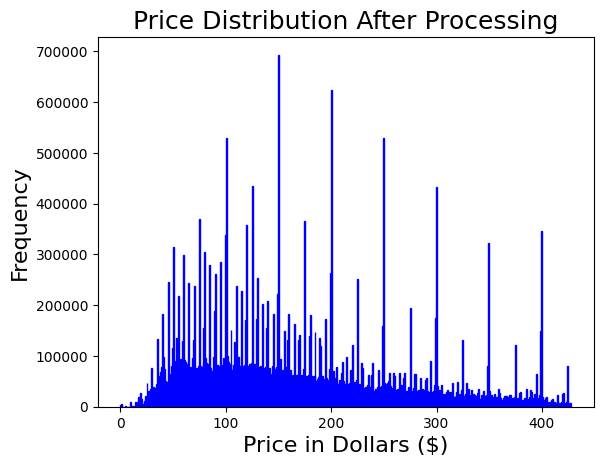

In [ ]:
plot_price_distribution(df['price'], 'Price Distribution After Processing')


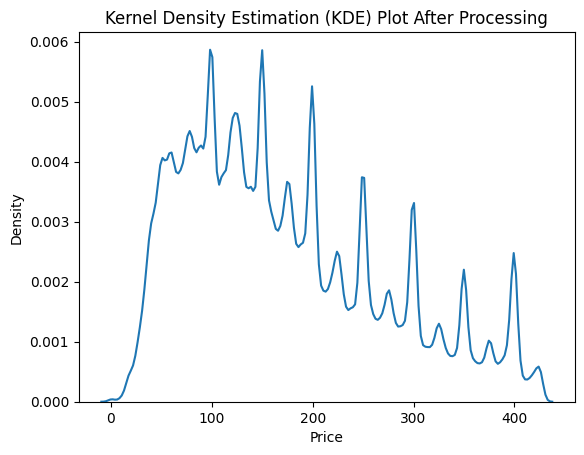

In [ ]:
plot_price_kde(df['price'], 'Kernel Density Estimation (KDE) Plot After Processing')


In [ ]:
# Seasonal Patterns
df['month'] = pd.to_datetime(df['date']).dt.month
df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek
seasonal_patterns = df.groupby('month')['price'].mean()  # Example: average price by month

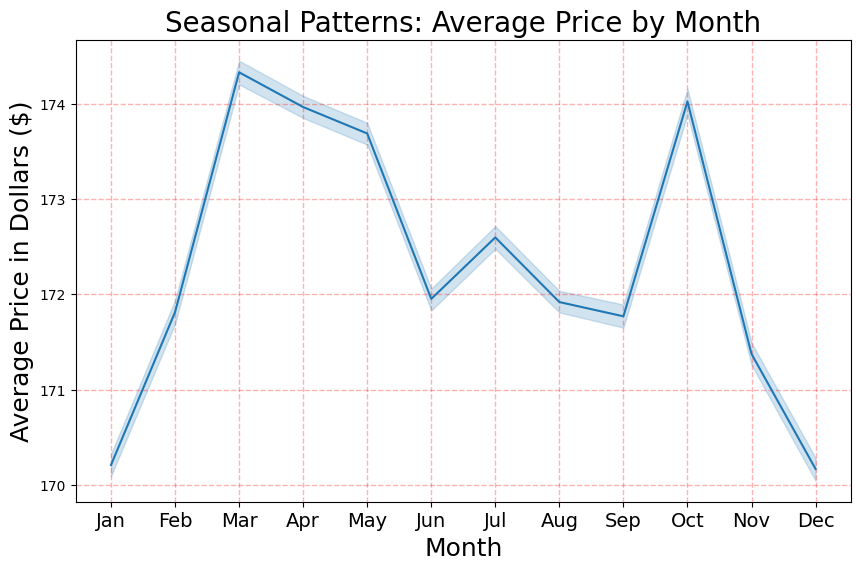

In [ ]:
# line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='month', y='price')
plt.grid(color='r', linestyle='--', linewidth=1, alpha=0.3)
plt.xlabel('Month', fontsize=18)
plt.ylabel('Average Price in Dollars ($)', fontsize=18)
plt.title('Seasonal Patterns: Average Price by Month', fontsize=20)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14)
plt.show()

The line plot visually represents the monthly fluctuations of Airbnb prices, providing a clear depiction of the observed trends and seasonal variations. There are two prominent peaks in average prices, with the first peak occurring in March and the second peak in October. The first peak in March indicates a potential correlation with seasonal trends, likely due to factors such as school breaks, vacations, and favorable weather conditions. Events like South by Southwest may also contribute to the increased demand and subsequently higher prices during this time. Similarly, the second peak in October suggests an association with events like the Austin City Limits Festival, cultural activities, and Halloween festivities.


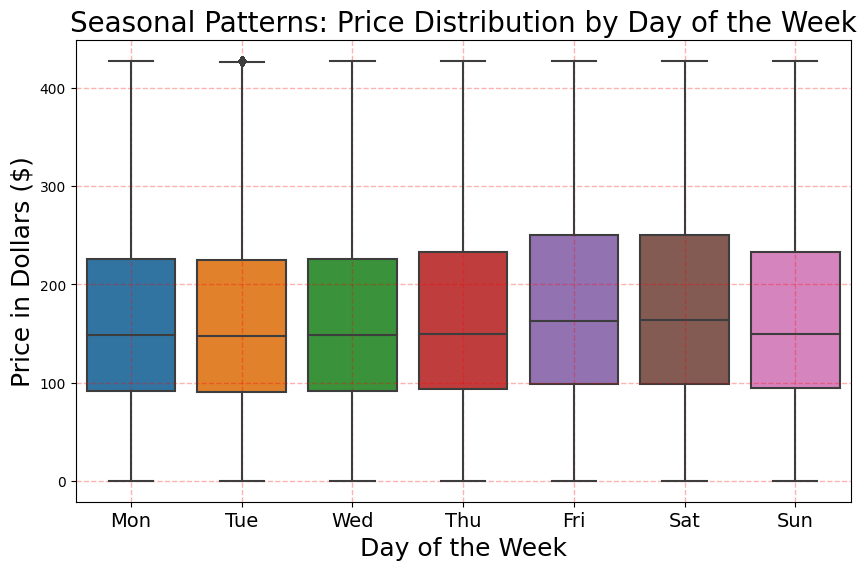

In [ ]:
#box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='day_of_week', y='price')
plt.grid(color='r', linestyle='--', linewidth=1, alpha=0.3)

plt.xlabel('Day of the Week', fontsize=18)
plt.ylabel('Price in Dollars ($)', fontsize=18)
plt.title('Seasonal Patterns: Price Distribution by Day of the Week', fontsize=20)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=14)
plt.show()

Variations of Airbnb prices by day of the week. The boxplot showcases the price variation of Airbnb listings based on different days of the week, with median prices of around 155 on Sunday to Thursday, and 180 Friday and Saturday, highlighting the typical price ranges for each category.